In [255]:
import numpy as np
import pandas as pd
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import math
from tqdm import tqdm
import matplotlib.pyplot as plt

In [72]:
# Load in GPT2 model
tokenizer = GPT2Tokenizer.from_pretrained('gpt2-large')
model = GPT2LMHeadModel.from_pretrained('gpt2-large')

In [291]:
# read in text (encoding UTF8)
with open("MonteCristo.txt","r",encoding="UTF-8") as f:
    text = f.read()

In [292]:
# decide the number of word to take into context
# here chosen as in:
#A tradeoff between acoustic and linguistic feature encoding in spoken language comprehension by Tezcan, Weissbart,Martin
nb_words_context = 30
# if True print the individual subtoken for each multitoken encoded word
printIt = True # True / False

In [293]:
#split into words and take care of dots maybe also any punctuation actually!

punkts = [',','.',';','!','?',':',' "','" ', " '","' ",'(',')']
space_punkts = [' ,',' .',' ;',' !',' ?',' :',' " ',' " '," ' "," ' ",'( ',' )']

for num in range(len(punkts)):
    text = text.replace(punkts[num],space_punkts[num])
splitted_text = text.split(' ')

In [294]:
#take only a subset for example
splitted_text = splitted_text[0:45]

In [295]:
# create sequence of lenght of at most nb_words_context
sequence = []
prevseqs = []
previds = []
prevdecods = []
surprisals = []
entropies = []
words = []
nbwcs = []
for num, word in enumerate(tqdm(splitted_text)):
    if len(sequence)<nb_words_context+1:
            sequence.append(splitted_text[num])
    else:
        sequence.pop(0)
        sequence.append(splitted_text[num])
    # recreate proper sentence
    curseq = ' '.join(sequence)
    # append previous sequence so that we can retrieve vocab id associated with last word of sequence
    prevseqs.append(curseq)
    # give the model the current sequence
    inputs = tokenizer(curseq, return_tensors="pt")
    # get the vocab id associated with each word in the sequence
    input_ids = inputs['input_ids']
    # append previous ids so that we can retrieve vocab id associated with last word of sequence
    previds.append(input_ids)
    # get the logits
    with torch.no_grad():
        outputs = model(input_ids, labels=input_ids)
        logits = outputs.logits
    # Look whether previous token is a full word or not
    
    # if full word: no problemo  BUT a list of token that do not have ' ' at the begining basically punctuation
    if tokenizer.decode(input_ids[0][-1]).startswith(" ") or tokenizer.decode(input_ids[0][-1]) in [',','.',';','!','?',':','"',"'","-",'(',')']:
        final_logits = logits[0,  - 1]
        probs = torch.nn.functional.softmax(final_logits, dim=-1)
        log_probs = torch.log2(probs)
        entropy = -torch.sum(probs * log_probs).item()
        surprisal = -log_probs[input_ids[0][-1]].item()
        entropies.append(entropy)
        surprisals.append(surprisal)
        words.append(word)
        nbwcs.append(len(sequence)-1)
        # if this is the first word it will start without ' ' at the begining
    elif len(input_ids[0]) == 1:
            final_logits = logits[0,  - 1]
            probs = torch.nn.functional.softmax(final_logits, dim=-1)
            log_probs = torch.log2(probs)
            entropy = -torch.sum(probs * log_probs).item()
            surprisal = -log_probs[input_ids[0][-1]].item()
            entropies.append(entropy)
            surprisals.append(surprisal)
            words.append(word)
            nbwcs.append(len(sequence)-1)

    else:
        # get start of the word in case of multiple tokens as they do not start with ' ' in this specific case
        idx = -1
        while tokenizer.decode(input_ids[0][idx]).startswith(" ") == False:
            idx = idx -1
        totake = [-i for i in np.arange(1,abs(idx)+1)[::-1]]
        
        curentro = []
        cursurprisal = []
        for ggind in  totake:
            final_logits = logits[0,   ggind]
            probs = torch.nn.functional.softmax(final_logits, dim=-1)
            log_probs = torch.log2(probs)
            entropy = -torch.sum(probs * log_probs).item()
            surprisal = -log_probs[input_ids[0][ggind]].item()
            curentro.append(entropy)
            cursurprisal.append(surprisal)
            # here you can print the slicind result
            if printIt:
                print(tokenizer.decode(input_ids[0][ggind]))
       
        # HERE we take the average over the subtokens I don't know whether sum or another operation should be better
        entropies.append(np.mean(curentro,0))
        surprisals.append(np.mean(cursurprisal,0))
        
        words.append(word)
        nbwcs.append(len(sequence)-1)




 11%|█████████▏                                                                         | 5/45 [00:01<00:08,  4.64it/s]

 Crist
o


 31%|█████████████████████████▌                                                        | 14/45 [00:03<00:08,  3.62it/s]

 Alexand
re


 33%|███████████████████████████▎                                                      | 15/45 [00:03<00:10,  3.00it/s]

 Dum
as


 36%|█████████████████████████████▏                                                    | 16/45 [00:04<00:09,  2.97it/s]

 serial
ized


 40%|████████████████████████████████▊                                                 | 18/45 [00:05<00:11,  2.45it/s]

 18
44


 44%|████████████████████████████████████▍                                             | 20/45 [00:06<00:11,  2.11it/s]

 18
46


 60%|█████████████████████████████████████████████████▏                                | 27/45 [00:09<00:09,  1.95it/s]

 author
's


 80%|█████████████████████████████████████████████████████████████████▌                | 36/45 [00:15<00:05,  1.76it/s]

 Mus
ket
eers


100%|██████████████████████████████████████████████████████████████████████████████████| 45/45 [00:21<00:00,  2.13it/s]


In [296]:
# create a dictionnary with the values
moby = {
    'word': words,
    'entropy':entropies,
    'surprisal': surprisals,
    'nb_words_in_context': nbwcs}
# create a dataframe out of the dictionnary
df = pd.DataFrame.from_dict(moby)
# save as a csv file
#df.to_csv('surprisal&entropy.csv', index=None)

In [297]:
print('Correlation between Surprisal and Entropy:')
np.corrcoef(df['entropy'].values,df['surprisal'].values)[0,1]

Correlation between Surprisal and Entropy:


-0.4979199070091965

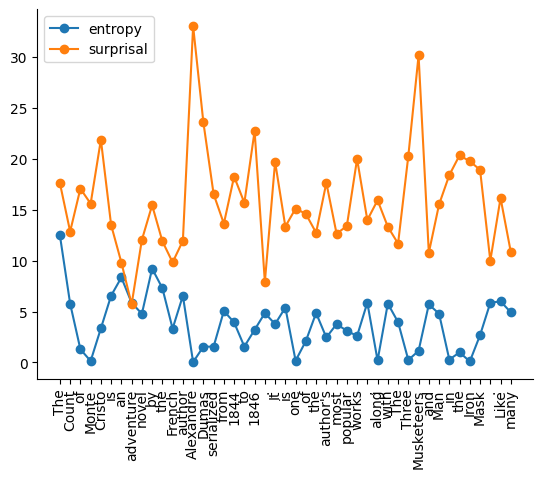

In [298]:
fig, ax = plt.subplots(1,1)
ax.plot(entropies,'-o',label='entropy');
ax.plot(surprisals,'-o',label="surprisal");
ax.legend()
ax.set_xticks(np.arange(0, len(words)))
ax.set_xticklabels(words, rotation=90);
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False);

In [ ]:
# here from the plot it seems like the words that are processed as multi token give higher scores of surprisal 
# (which makes sense they are quite rate) but still maybe taking the average value may inflate the results IDK.

In [313]:
df

,word,entropy,surprisal,nb_words_in_context
0,The,12.494858,17.629808,0
1,Count,5.772919,12.863962,1
2,of,1.289325,17.082891,2
3,Monte,0.132022,15.607231,3
4,Cristo,3.342999,21.891479,4
5,is,6.562407,13.502480,5
6,an,8.346440,9.816053,6
7,adventure,5.858706,5.713222,7
8,novel,4.775571,12.042246,8
9,by,9.220105,15.451877,9
